# 照相机静止不动时的calibration结果处理

## 介绍

3个file：from0，from10，from23三个csv文件，记录的是从三个marker获得的camera_to_base的transformation，

格式为(x,y,z,alpha,beta,gamma)

In [38]:
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

import sys
import numpy as np
import scipy as sp
import IPython
import pandas as pd
import csv
import cv2

ModuleNotFoundError: No module named 'cv2'

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from scipy import stats


#Configure Visualization Defaults
#%matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline
mpl.style.use('ggplot')
pylab.rcParams['figure.figsize'] = 12,8

## ground truth of calibration parameter 

In [6]:
xt = -0.100
yt = 0.87529999
zt = 0.62499994
at = 1.57079633
bt = 0.00
ct = 0.00

## 读入三个csv文件

In [7]:
data_from0 = pd.read_csv("from0.txt",delimiter = " ")
data_from10 = pd.read_csv("from10.txt",delimiter = " ")
data_from23 = pd.read_csv("from23.txt",delimiter = " ")

In [8]:
print(data_from0)

            x         y         z     alpha      beta     gamma
0   -0.104367  0.885310  0.631260  1.580074  0.000891  0.008160
1   -0.095828  0.881758  0.621216  1.566963  0.000107 -0.003086
2   -0.095804  0.881763  0.621175  1.566950  0.000203 -0.003082
3   -0.095779  0.881768  0.621133  1.566936  0.000299 -0.003078
4   -0.095755  0.881773  0.621092  1.566923  0.000396 -0.003074
..        ...       ...       ...       ...       ...       ...
428 -0.102713  0.884629  0.634183  1.583012 -0.000819  0.006621
429 -0.105460  0.890181  0.627736  1.575237 -0.001320  0.012165
430 -0.097532  0.884159  0.622657  1.569394  0.001184  0.001199
431 -0.097865  0.884009  0.623477  1.569964  0.000167  0.001249
432 -0.097818  0.883890  0.623781  1.570182 -0.000190  0.001093

[433 rows x 6 columns]


## 三组数据的分布情况

In [9]:
data_from23.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 433 entries, 0 to 432
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       433 non-null    float64
 1   y       433 non-null    float64
 2   z       433 non-null    float64
 3   alpha   433 non-null    float64
 4   beta    433 non-null    float64
 5   gamma   433 non-null    float64
dtypes: float64(6)
memory usage: 20.4 KB


In [10]:
data_from0.describe()

,x,y,z,alpha,beta,gamma
count,433.000000,433.000000,433.000000,433.000000,433.000000,433.000000
mean,-0.072611,0.643692,0.458397,1.151657,-0.000277,0.000034
std,0.044645,0.390019,0.277729,0.697537,0.002196,0.007242
min,-0.172482,0.000000,0.000000,0.000000,-0.014911,-0.032318
25%,-0.100116,0.000000,0.000000,0.000000,-0.001012,-0.003078
50%,-0.095779,0.879578,0.622524,1.568732,-0.000000,0.000000
75%,0.000000,0.882614,0.627316,1.574824,0.000396,0.002457
max,0.000000,0.891764,0.681156,1.644100,0.022092,0.046263


In [11]:
data_from10.describe()

,x,y,z,alpha,beta,gamma
count,433.000000,433.000000,433.000000,433.000000,433.000000,433.000000
mean,-0.100670,0.881818,0.624827,1.151657,-0.000277,0.000034
std,0.016079,0.005350,0.015651,0.697537,0.002196,0.007242
min,-0.163900,0.868203,0.544234,0.000000,-0.014911,-0.032318
25%,-0.107449,0.877914,0.616122,0.000000,-0.001012,-0.003078
50%,-0.100561,0.881229,0.624647,1.568732,-0.000000,0.000000
75%,-0.093475,0.885392,0.632851,1.574824,0.000396,0.002457
max,-0.038417,0.901527,0.685559,1.644100,0.022092,0.046263


In [12]:
data_from23.describe()

,x,y,z,alpha,beta,gamma
count,433.000000,433.000000,433.000000,433.000000,433.000000,433.000000
mean,-0.096510,0.859400,0.610328,1.151657,-0.000277,0.000034
std,0.023793,0.132464,0.095717,0.697537,0.002196,0.007242
min,-0.164644,0.000000,0.000000,0.000000,-0.014911,-0.032318
25%,-0.107365,0.878266,0.613518,0.000000,-0.001012,-0.003078
50%,-0.098397,0.880569,0.624592,1.568732,-0.000000,0.000000
75%,-0.088311,0.882430,0.633977,1.574824,0.000396,0.002457
max,0.000000,0.890282,0.686188,1.644100,0.022092,0.046263


In [13]:
drop_0=data_from0.index[data_from0['x'] == 0].tolist()
c= drop_0
df0=data_from0.drop(data_from0.index[c])
df0.describe()


,x,y,z,alpha,beta,gamma
count,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000
mean,-0.099182,0.879239,0.626138,1.573083,-0.000378,0.000047
std,0.009009,0.014062,0.009285,0.011458,0.002560,0.008467
min,-0.172482,0.778809,0.610620,1.553703,-0.014911,-0.032318
25%,-0.102607,0.878863,0.621094,1.566936,-0.001783,-0.004494
50%,-0.097865,0.881609,0.625074,1.572382,-0.000159,-0.000460
75%,-0.095163,0.883655,0.629630,1.577306,0.000771,0.005530
max,-0.082529,0.891764,0.681156,1.644100,0.022092,0.046263


In [14]:
drop_10=data_from10.index[data_from10['x'] == 0].tolist()
c= drop_10
df10=data_from10.drop(data_from10.index[c])
df10.describe()


,x,y,z,alpha,beta,gamma
count,433.000000,433.000000,433.000000,433.000000,433.000000,433.000000
mean,-0.100670,0.881818,0.624827,1.151657,-0.000277,0.000034
std,0.016079,0.005350,0.015651,0.697537,0.002196,0.007242
min,-0.163900,0.868203,0.544234,0.000000,-0.014911,-0.032318
25%,-0.107449,0.877914,0.616122,0.000000,-0.001012,-0.003078
50%,-0.100561,0.881229,0.624647,1.568732,-0.000000,0.000000
75%,-0.093475,0.885392,0.632851,1.574824,0.000396,0.002457
max,-0.038417,0.901527,0.685559,1.644100,0.022092,0.046263


In [15]:
drop_23=data_from23.index[data_from23['x'] == 0].tolist()
c= drop_23
df23=data_from23.drop(data_from23.index[c])
df23.describe()

,x,y,z,alpha,beta,gamma
count,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000
mean,-0.098791,0.879716,0.624757,1.167757,-0.000291,0.000044
std,0.018804,0.006865,0.018522,0.688906,0.002202,0.007320
min,-0.164644,0.834900,0.560559,0.000000,-0.014911,-0.032318
25%,-0.107591,0.878453,0.614892,0.000000,-0.001037,-0.003084
50%,-0.098716,0.880613,0.624840,1.569086,-0.000000,0.000000
75%,-0.089594,0.882434,0.634025,1.574987,0.000397,0.002609
max,-0.035732,0.890282,0.686188,1.644100,0.022092,0.046263


## 绘制

In [16]:
print(data_from23['x'])

0     -0.089843
1     -0.089815
2     -0.089787
3     -0.089759
4     -0.089731
         ...   
428   -0.114351
429   -0.077287
430   -0.141546
431   -0.068708
432   -0.097806
Name: x, Length: 433, dtype: float64


In [17]:
print(df10['x'])

0     -0.099641
1     -0.099643
2     -0.099645
3     -0.099646
4     -0.099648
         ...   
428   -0.105932
429   -0.115223
430   -0.113357
431   -0.082347
432   -0.078110
Name: x, Length: 433, dtype: float64


## 通过marker0获得，marker0在link4上

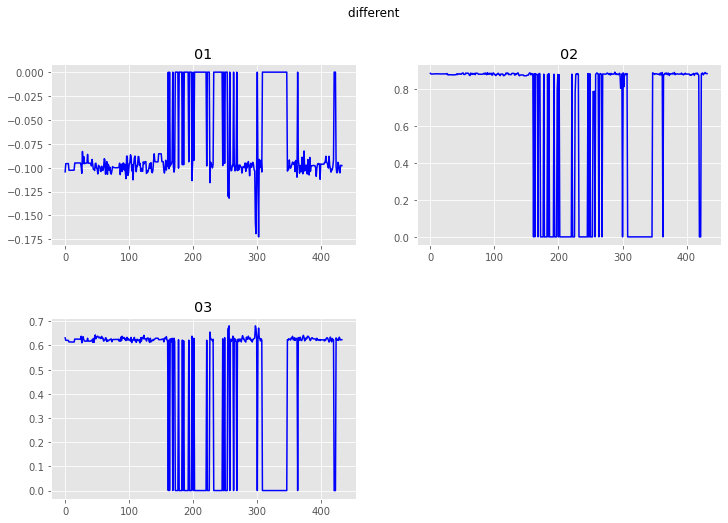

In [30]:
x = data_from0['x']
y = data_from0['y']
z = data_from0['z']

fig = plt.figure()
fig.suptitle('different ')
fig.subplots_adjust(hspace=0.4)

ax221 = fig.add_subplot(221)  
ax221.set_title('01')
ax221.plot(x, color='blue')
ax222 = fig.add_subplot(222)
ax222.set_title('02')
ax222.plot(y, color='blue')
ax223 = fig.add_subplot(223)
ax223.set_title('03')
ax223.plot(z, color='blue')

### 去零

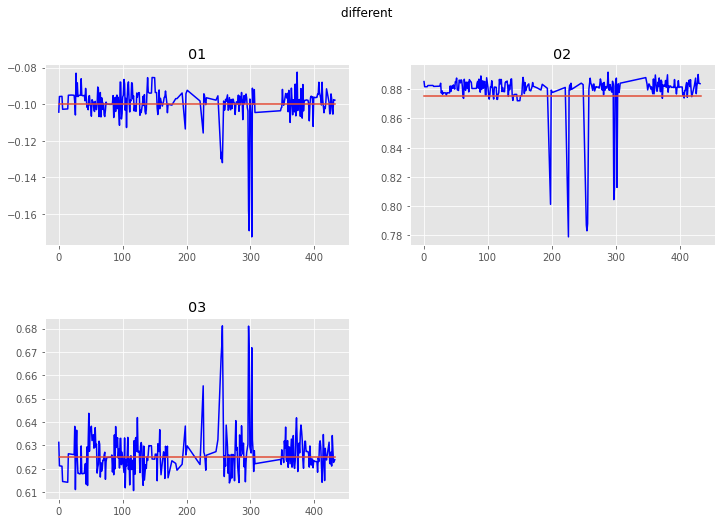

In [31]:
x0 = df0['x']
y0 = df0['y']
z0 = df0['z']

fig = plt.figure()
fig.suptitle('different ')
fig.subplots_adjust(hspace=0.4)

ax221 = fig.add_subplot(221)  
ax221.set_title('01')
ax221.plot(x0, color='blue')
x_coordinates = [0,len(data_from0['x'])]
y_coordinates = [xt, xt]
ax221.plot(x_coordinates, y_coordinates)

ax222 = fig.add_subplot(222)
ax222.set_title('02')
ax222.plot(y0, color='blue')
x_coordinates = [0,len(data_from0['x'])]
y_coordinates = [yt, yt]
ax222.plot(x_coordinates, y_coordinates)

ax223 = fig.add_subplot(223)
ax223.set_title('03')
ax223.plot(z0, color='blue')
ax223.plot(zt,color='red')
x_coordinates = [0,len(data_from0['x'])]
y_coordinates = [zt, zt]
ax223.plot(x_coordinates, y_coordinates)

## 通过marker23获得，在link6上

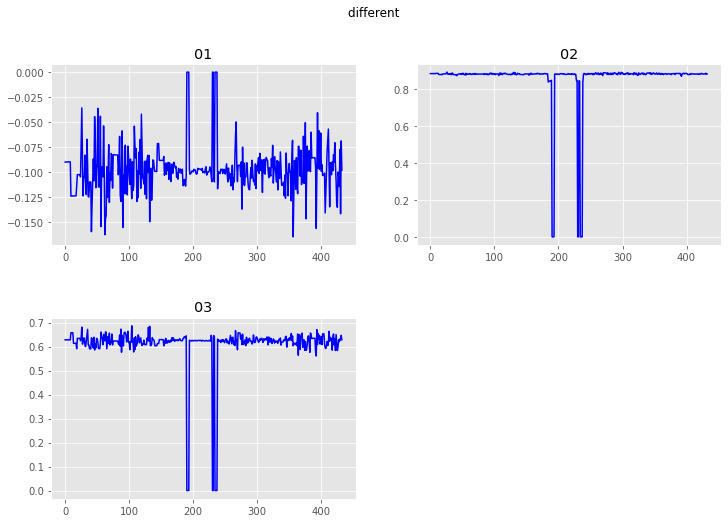

In [20]:
x = data_from23['x']
y = data_from23['y']
z = data_from23['z']

fig = plt.figure()
fig.suptitle('different ')
fig.subplots_adjust(hspace=0.4)

ax221 = fig.add_subplot(221)  
ax221.set_title('01')
ax221.plot(x, color='blue')
ax222 = fig.add_subplot(222)
ax222.set_title('02')
ax222.plot(y, color='blue')
ax223 = fig.add_subplot(223)
ax223.set_title('03')
ax223.plot(z, color='blue')

### 去零

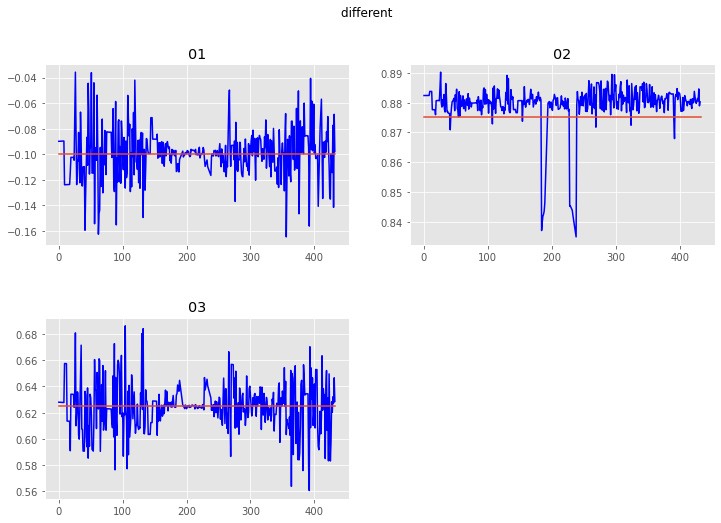

In [32]:
x23 = df23['x']
y23 = df23['y']
z23 = df23['z']

fig = plt.figure()
fig.suptitle('different ')
fig.subplots_adjust(hspace=0.4)

ax221 = fig.add_subplot(221)  
ax221.set_title('01')
ax221.plot(x23, color='blue')
x_coordinates = [0,len(data_from0['x'])]
y_coordinates = [xt, xt]
ax221.plot(x_coordinates, y_coordinates)

ax222 = fig.add_subplot(222)
ax222.set_title('02')
ax222.plot(y23, color='blue')
x_coordinates = [0,len(data_from0['x'])]
y_coordinates = [yt, yt]
ax222.plot(x_coordinates, y_coordinates)

ax223 = fig.add_subplot(223)
ax223.set_title('03')
ax223.plot(z23, color='blue')
ax223.plot(zt,color='red')
x_coordinates = [0,len(data_from0['x'])]
y_coordinates = [zt, zt]
ax223.plot(x_coordinates, y_coordinates)

## 通过marker10获得，位于link8上

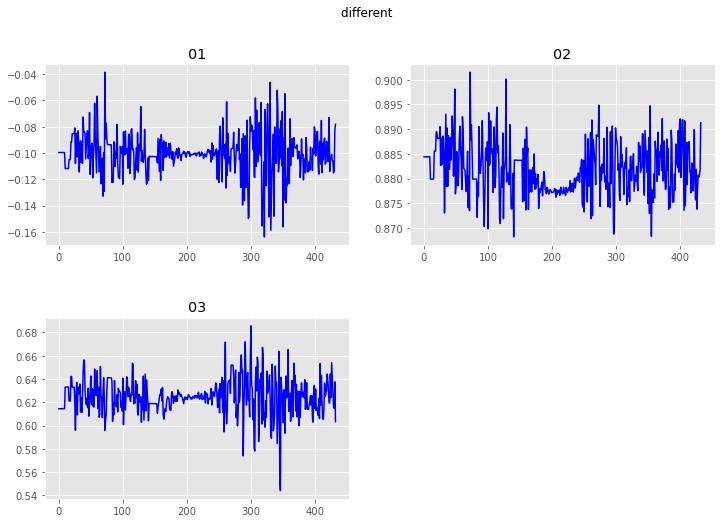

In [22]:
x = data_from10['x']
y = data_from10['y']
z = data_from10['z']

fig = plt.figure()
fig.suptitle('different ')
fig.subplots_adjust(hspace=0.4)

ax221 = fig.add_subplot(221)  
ax221.set_title('01')
ax221.plot(x, color='blue')
ax222 = fig.add_subplot(222)
ax222.set_title('02')
ax222.plot(y, color='blue')
ax223 = fig.add_subplot(223)
ax223.set_title('03')
ax223.plot(z, color='blue')


### 去零

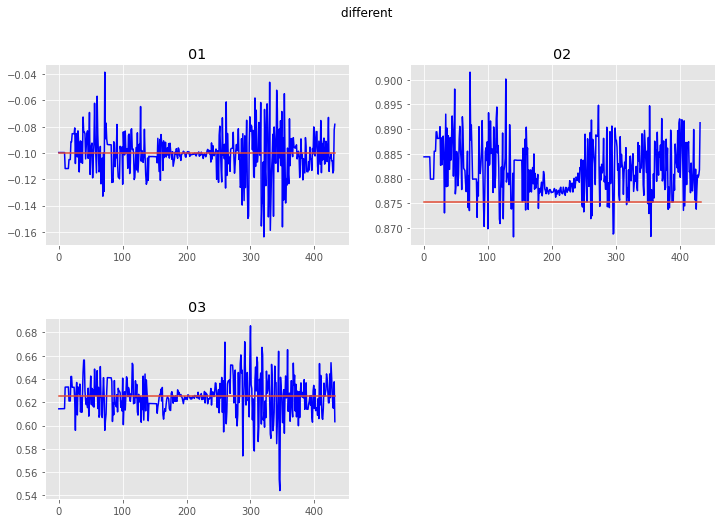

In [33]:
x10 = df10['x']
y10 = df10['y']
z10 = df10['z']

fig = plt.figure()
fig.suptitle('different ')
fig.subplots_adjust(hspace=0.4)

ax221 = fig.add_subplot(221)  
ax221.set_title('01')
ax221.plot(x10, color='blue')
x_coordinates = [0,len(data_from0['x'])]
y_coordinates = [xt, xt]
ax221.plot(x_coordinates, y_coordinates)

ax222 = fig.add_subplot(222)
ax222.set_title('02')
ax222.plot(y10, color='blue')
x_coordinates = [0,len(data_from0['x'])]
y_coordinates = [yt, yt]
ax222.plot(x_coordinates, y_coordinates)

ax223 = fig.add_subplot(223)
ax223.set_title('03')
ax223.plot(z10, color='blue')
ax223.plot(zt,color='red')
x_coordinates = [0,len(data_from0['x'])]
y_coordinates = [zt, zt]
ax223.plot(x_coordinates, y_coordinates)

## 去零后汇总

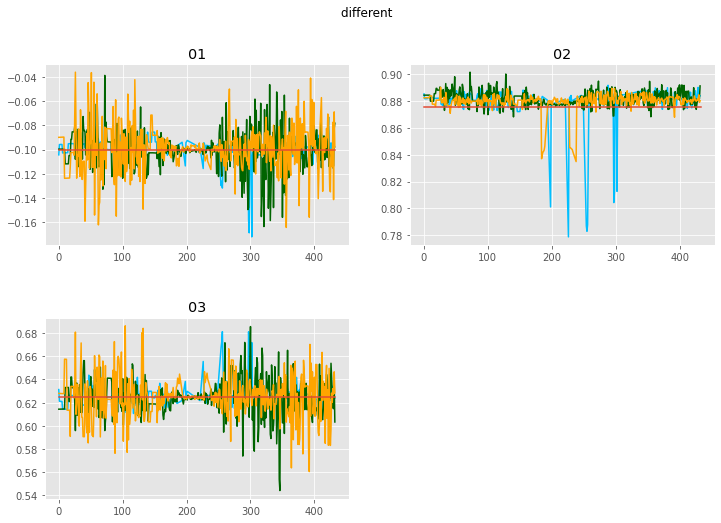

In [35]:
fig = plt.figure()
fig.suptitle('different ')
fig.subplots_adjust(hspace=0.4)

ax221 = fig.add_subplot(221)  
ax221.set_title('01')
ax221.plot(x0, color='deepskyblue')
ax221.plot(x10, color='darkgreen')
ax221.plot(x23, color='orange')
x_coordinates = [0,len(data_from0['x'])]
y_coordinates = [xt, xt]
ax221.plot(x_coordinates, y_coordinates)

ax222 = fig.add_subplot(222)
ax222.set_title('02')
ax222.plot(y0, color='deepskyblue')
ax222.plot(y10, color='darkgreen')
ax222.plot(y23, color='orange')
x_coordinates = [0,len(data_from0['x'])]
y_coordinates = [yt, yt]
ax222.plot(x_coordinates, y_coordinates)

ax223 = fig.add_subplot(223)
ax223.set_title('03')
ax223.plot(z0, color='deepskyblue')
ax223.plot(z10, color='darkgreen')
ax223.plot(z23, color='orange')
ax223.plot(zt,color='red')
x_coordinates = [0,len(data_from0['x'])]
y_coordinates = [zt, zt]
ax223.plot(x_coordinates, y_coordinates)

## 卡尔曼滤波器